In [1]:
import numpy as np 
import math 
from sklearn.metrics import mean_squared_error

### 数据准备部分

In [2]:
def shuffle_data(X,y,seed=None):
    "将X和y的数据进行随机排序/乱序化"
    if seed:
        np.random.seed(seed)
    idx=np.arange(X.shape[0])
    print(type(idx))
    np.random.shuffle(idx)
    return X[idx],y[idx] #对于np.array，idx作为index数组可以改变array的顺序

In [3]:
def train_test_split(X,y,test_size=0.5,shuffle=True,seed=None):
    '将数据集根据test_size分成训练集和测试集，可以指定是否随机洗牌'
    if shuffle:
        X,y=shuffle_data(X,y,seed)
    split_i=len(y)-int(len(y)//(1/test_size))
    #split_i=len(y)-int(len(y)*test_size)
    X_train,X_test=X[:split_i],X[split_i:]
    y_train,y_test=y[:split_i],y[split_i:]
    
    return X_train,X_test,y_train,y_test

In [4]:
from sklearn.datasets import make_regression
import matplotlib.pylab as plt

In [5]:
X,y=make_regression(n_samples=100,n_features=1,noise=20)

In [6]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

<class 'numpy.ndarray'>


因为使用make_regression函数使得X乱序，在绘制matplot的图像时会有问题，所以对于X进行排序

In [7]:
s=sorted([(X_test[i][0],y_test[i]) for i in range(len(X_test))],key=lambda j:j[0])

In [8]:
s

[(-1.474442480809217, -147.74947543543965),
 (-1.197098621960897, -99.30313890537829),
 (-0.9936269178305394, -101.41315814434762),
 (-0.823281018932491, -69.61600545558895),
 (-0.6701059142730587, -27.920643810481337),
 (-0.654036359140512, -85.60114606184531),
 (-0.42539055439090495, -46.55235022031978),
 (-0.39394221606217544, -17.238356515022886),
 (-0.21560187894104596, 31.09741586413786),
 (-0.11451497121516079, -25.290704432553596),
 (-0.04927329034535876, -7.5976712430948155),
 (0.2642188378264098, -6.526950131936811),
 (0.5532518166360719, 50.91782596939433),
 (0.5911276457340608, 78.96151465565015),
 (0.6604089576473124, 63.438209574893406),
 (1.211777345957457, 70.84566948107124),
 (1.272009202563754, 89.94524158778205),
 (1.5998873616698344, 123.36327786823506),
 (1.8856397354523848, 150.91093912335),
 (2.5386011218502067, 171.79984121175755)]

In [9]:
X_test=np.array([[j[0]] for j in s])
y_test=np.array([j[1] for j in s])

In [10]:
#y_test

## 线性回归

In [11]:
class Regression(object):
    
    """
        基础线性回归模型，使用输入的X和y进行参数回归
        超参：
        n_iterations:int 训练的步数
        learning_rate:float 学习率
        内部函数:
        initialize_weights:初始化参数
        fit:开始训练
        predict:预测
        内部的数据:
        n_iterations
        learning_rate
        regularization:正则化参数
        regularization.grad:正则化的梯度函数
    """
    
    def __init__(self,n_iterations,learning_rate):
        self.n_iterations=n_iterations
        self.learning_rate=learning_rate
        self.regularization=lambda x:0
        self.regularization.grad=lambda x:0
    
    def initialize_weights(self,n_features):
        """初始化系数，输入是feature的个数，输出是一个随机初始化好的参数矩阵,[-1/sqrt(N),1/sqrt(N)]"""
        limit=1/math.sqrt(n_features)
        self.w=np.random.uniform(-limit,limit,(n_features,))
        #Uniform Distribution/Xavier/MSRA/Gaussian
        
    def fit(self,X,y):
        #插入偏置列1到X中
        X=np.insert(X,0,1,axis=1)#给每一行的第0列增加一个1
        self.training_errors=[]#保存每一次步长的训练Loss
        self.initialize_weights(n_features=X.shape[1])#初始化参数w
        
        #进行梯度下降迭代
        for i in range(self.n_iterations):
            y_pred=X.dot(self.w)#进行预测
            #计算Loss
            mse=np.mean(0.5*(y-y_pred)**2+self.regularization(self.w))
            self.training_errors.append(mse)#将Loss加入到training_errors的数组中
            #计算带有正则化项的梯度
            g_w=-(y-y_pred).T.dot(X)/len(X)+self.regularization.grad(self.w)
            #根据梯度下降的算法更新参数
            self.w-=self.learning_rate*g_w
            
    def predict(self,X):
        #通过输入X预测一个样本
        X=np.insert(X,0,1,axis=1)
        pred=X.dot(self.w)
        return pred
    

In [12]:
model=Regression(n_iterations=1000,learning_rate=0.01)

In [13]:
model.fit(X_train,y_train)

Text(0.5, 0, 'Steps')

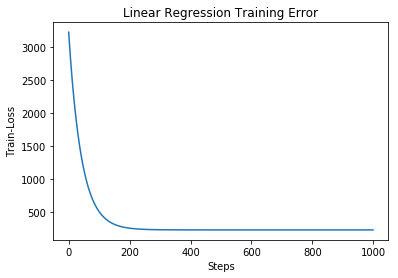

In [14]:
training,=plt.plot(range(len(model.training_errors)),model.training_errors,label="Training Error")
plt.title("Linear Regression Training Error")
plt.ylabel("Train-Loss")
plt.xlabel("Steps")

In [15]:
model.w

array([-1.74911171, 70.89193092])

### 评价模型

In [16]:
y_pred=model.predict(X_test)

In [17]:
mse=mean_squared_error(y_pred,y_test)

In [18]:
mse

545.4751105388116

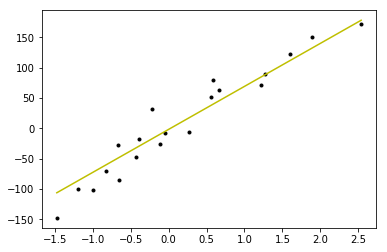

In [19]:
plt.plot(X_test,y_test,'k.')
plt.plot(X_test,y_pred,'Y')

### 带有最小二乘法的线性回归

In [20]:
def lsm_function(X,y):
    G=np.mat(np.insert(X,0,1,axis=1))
    return np.squeeze(np.asarray((G.T.dot(G)).I.dot(G.T).dot(y)))

In [21]:
lsm_function(X_train,y_train)

array([-1.74834839, 70.89256963])

In [22]:
class LinearRegression(Regression):
    """带有最小二乘法的线性回归
    参数:
    -------------
    n_iterations
    
    learning_rate
    
    gradient_descent:bool 
        决定是否使用梯度下降法，如果是True则使用梯度下降，False使用最小二乘
    """
    def __init__(self,n_iterations=500,learning_rate=0.1,gradient_descent=True):
        self.gradient_descent=gradient_descent
        self.regularization=lambda x:0
        self.regularization.grad=lambda x:0
        super(LinearRegression,self).__init__(n_iterations=n_iterations,learning_rate=learning_rate)
    
    def fit(self,X,y):
        if not self.gradient_descent:
            self.w=lsm_function(X,y)
        else:
            super(LinearRegression,self).fit(X,y)
    
    def predict(self,X):
        return super(LinearRegression,self).predict(X)
        

In [23]:
model=LinearRegression(n_iterations=1000,learning_rate=0.1,gradient_descent=False)

In [24]:
model.fit(X_train,y_train)

In [25]:
model.w

array([-1.74834839, 70.89256963])

In [26]:
def test_and_draw(model):
    y_pred=model.predict(X_test)
    mse=mean_squared_error(y_test,y_pred)
    print("方差:",mse)
    plt.plot(X_test,y_test,'k.')
    plt.plot(X_test,y_pred,'Y')

方差: 545.465461234118


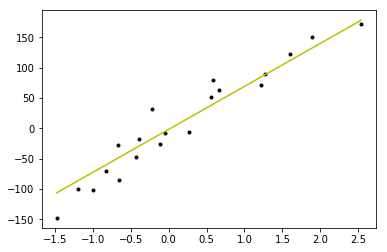

In [27]:
test_and_draw(model)

## 正则化回归

### L1正则化参数

In [28]:
class l1_regularization():
    """L1正则化类/函数
    参数:
    
    alpha--L1正则化系数
    """
    def __init__(self,alpha):
        self.alpha=alpha
    def __call__(self,w):
        return self.alpha*np.linalg.norm(w,ord=1)
    def grad(self,w):
        #w>0->w`=1;w<0->w`=0;w==0->w`=0
        return self.alpha*np.sign(w)

In [29]:
l1=l1_regularization(alpha=0.01)

In [30]:
l1([-3,4])

0.07

In [31]:
l1.grad([-3,4,0])

array([-0.01,  0.01,  0.  ])

### L2正则化参数

In [32]:
class l2_regularization():
    """L2正则化参数
    参数：
    
    alpha 正则化系数
    """
    def __init__(self,alpha):
        self.alpha=alpha
    
    def __call__(self,w):
        return self.alpha*0.5*w.T.dot(w)
    
    def grad(self,w):
        return self.alpha*w

### Lasso线性回归

In [33]:
class LassoLinearRegression(Regression):
    def __init__(self,alpha,n_iterations=1000,learning_rate=0.01):
        self.regularization=l1_regularization(alpha=alpha)
        super(LassoLinearRegression,self).__init__(n_iterations,learning_rate)
        
    def fit(self,X,y):
        super(LassoLinearRegression,self).fit(X,y)
    def predict(self,X):
        return super(LassoLinearRegression,self).predict(X)

In [34]:
model=LassoLinearRegression(alpha=120,n_iterations=1000,learning_rate=0.1)

In [35]:
model.fit(X_train,y_train)

In [36]:
model.w

array([-1.74834839, 70.89256963])

方差: 545.4654612341182


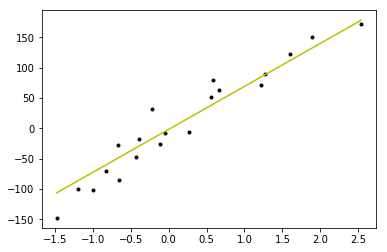

In [37]:
test_and_draw(model)

### Ridge线性回归

In [38]:
class RidgeLinearRegression(Regression):
    def __init__(self,alpha,n_iterations=1000,learning_rate=0.01):
        self.regularization=l2_regularization(alpha=alpha)
        super(RidgeLinearRegression,self).__init__(n_iterations,learning_rate)
        
    def fit(self,X,y):
        super(RidgeLinearRegression,self).fit(X,y)
    def predict(self,X):
        return super(RidgeLinearRegression,self).predict(X)

In [39]:
model=RidgeLinearRegression(alpha=120,n_iterations=1000,learning_rate=0.1)

In [40]:
model.fit(X_train,y_train)

In [41]:
model.w

array([-1.74834839, 70.89256963])

方差: 545.4654612341182


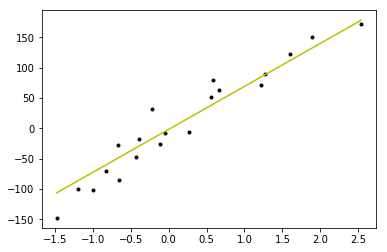

In [42]:
test_and_draw(model)

### L1，L2调和的正则化

在调和的正则化中，

l1_ratio:调和时，L1正则化的值所占的百分比[0,1]

_l2_ratio=1-l1_ratio(事实上在算法中也找不到l2_ratio)

alpha:全局的整体的正则化权重

#### $Loss = mse + \alpha(l1\_ratio * L1Loss + (1-l1\_ratio) * L2Loss)$

In [43]:
class l1_l2_regularization():
    """使用在ElasticNet中的正则化"""
    
    def __init__(self,alpha,l1_ratio=0.5):
        self.alpha=alpha
        self.l1_ratio=l1_ratio
    
    def __call__(self,w):
        l1_loss=self.l1_ratio*np.linalg.norm(w,ord=1)
        l2_loss=(1-self.l1_ratio)*0.5*w.T.dot(w)#np.linalg.norm(w,ord=2)**2
        return self.alpha*(l1_loss+l2_loss)
    def grad(self,w):
        l1_grad=self.l1_ratio*np.sign(w)
        l2_grad=(1-self.l1_ratio)*w
        return self.alpha*(l1_grad+l2_grad)
        

In [44]:
l1_l2=l1_l2_regularization(alpha=0.1)

In [45]:
l1_l2(np.array([3,4]))

0.9750000000000001

In [46]:
l1_l2.grad(np.array([3,4]))

array([0.2 , 0.25])

In [47]:
0.5*np.sign(np.array([3,4]))

array([0.5, 0.5])

In [48]:
0.5*np.array([3,4])

array([1.5, 2. ])

### ElasticNetLinearRegression

In [49]:
class ElasticNetLinearRegression(Regression):
    """
    ElasticNet线性回归算法
    ----------------------
    alpha:全局正则化参数
    l1_ratio:L1正则化参数比例
    n_iterations
    learning_rate
    """
    def __init__(self,alpha=0.05,l1_ratio=0.5,n_iterations=3000,learning_rate=0.01):
        self.regularization=l1_l2_regularization(alpha=alpha,l1_ratio=l1_ratio)
        super(ElasticNetLinearRegression,self).__init__(n_iterations,learning_rate)
    def fit(self,X,y):
        super(ElasticNetLinearRegression,self).fit(X,y)
    def predict(self,X):
        return super(ElasticNetLinearRegression,self).predict(X)

In [50]:
model=ElasticNetLinearRegression(l1_ratio=0.5,alpha=1.2)

In [51]:
model.fit(X_train,y_train)

方差: 545.4654612341247


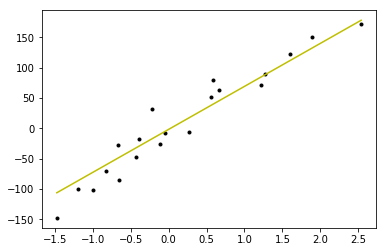

In [52]:
test_and_draw(model)

## 多项式回归

一阶多项式:x,y,z,x2,x3,x4....

二阶多项式:x1^2,x2^2,x3^2,x1x2,x1x3,x2x3

三阶多项式:x1^3,x1x1x2,x1x2x3....

### 构造多项式特征

In [53]:
from itertools import combinations_with_replacement

def polynomial_features(X,degree):
    n_samples,n_features=np.shape(X)
    ##对于每一行的Feature构造排列组合，根据排列组合进行特征的乘积，形成新的X`
    
    def index_combinations():
        combs=[combinations_with_replacement(range(n_features),i) for i in range(0,degree+1)]
        new_combs=[item for sub in combs for item in sub]
        return new_combs
    #print("Feature 列的排列组合:->",[x for x in index_combinations()])
    comb=index_combinations()
    feature_length=len(comb)
    output=np.empty((n_samples,feature_length))
    #print(output.shape)
    for i,index_combs in enumerate(comb):
        output[:,i]=np.prod(X[:, index_combs], axis=1)
    return output 

In [54]:
polynomial_features(np.array([[1,2],[4,5]]),degree=3)

array([[  1.,   1.,   2.,   1.,   2.,   4.,   1.,   2.,   4.,   8.],
       [  1.,   4.,   5.,  16.,  20.,  25.,  64.,  80., 100., 125.]])

In [55]:
### combinations_with_replacement

In [56]:
for x in combinations_with_replacement([0,1],0):print(x)

()


In [57]:
class PolyRegression(Regression):
    """多项式回归就是将原来的feature转化成多阶的新feature，之后进行线性回归:
    
    ------------------------------------------
    
    degree:最大的阶数
    
    n_iterations:float
    
    learning_rate:float
    
    """
    def __init__(self,degree,n_iterations=3000,learning_rate=0.01):
        
        self.degree=degree
        
        self.regularization=lambda x:0
        
        self.regularization.grad=lambda x:0
        
        super(PolyRegression,self).__init__(n_iterations=n_iterations,learning_rate=learning_rate)
        
    def fit(self,X,y):
        
        X=polynomial_features(X,degree=self.degree)
        
        super(PolyRegression,self).fit(X,y)
        
    def predict(self,X):
        
        X=polynomial_features(X,degree=self.degree)
        
        return super(PolyRegression,self).predict(X)

In [58]:
model=PolyRegression(degree=5)

In [59]:
model.fit(X_train,y_train)

C:\Users\lizhi\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: overflow encountered in square
C:\Users\lizhi\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in subtract


In [61]:
model.w

array([nan, nan, nan, nan, nan, nan, nan])

In [60]:
test_and_draw(model)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

### 数据的Normalize变换(归一化操作)

行归一化

In [ ]:
def normalize(X,axis=-1,order=2):
    "将数据集的每一行进行列的归一化--每一行的向量的L2范数归一"
    L2=np.linalg.norm(X,order,axis)
    L2[L2==0]=1#为了滤掉为0的L2距离，在归一化的时候会出现除零问题
    return X/np.expand_dims(L2,axis)

In [ ]:
normalize([[1,2],[3,4]],order=2,axis=-1)

In [ ]:
class LassoRegression(Regression):
    """带有L1范数的Lasso多项式回归
    ---------------------------
    degree:多项式的最高阶
    
    alpha:L1的系数
    
    n_iteration:float
    
    learning_rate:int
    
    normailzed:bool
    
    """
    
    def __init__(self,degree,alpha,n_iterations=3000,learning_rate=0.01,normalized=True):
        self.degree=degree
        self.regularization=l1_regularization(alpha=alpha)
        self.normalized=normalized
        super(LassoRegression,self).__init__(n_iterations,learning_rate)
        
    def fit(self,X,y):
        X=polynomial_features(X,degree=self.degree)
        if self.normalized:
            X=normalize(X)
        super(LassoRegression,self).fit(X,y)
    def predict(self,X):
        X=polynomial_features(X,degree=self.degree)
        if self.normalized:
            X=normalize(X)
        return super(LassoRegression,self).predict(X)

In [ ]:
model=LassoRegression(degree=5,alpha=1000,n_iterations=2000,learning_rate=0.1)

In [ ]:
model.fit(X_train,y_train)

In [ ]:
model.w

In [ ]:
test_and_draw(model)

### 带有多项式的Ridge 回归

In [ ]:
class RidgeRegression(Regression):
    """带有多项式和归一化的Ridge回归
    -----------------------------
    degree:最大阶数
    alpha:正则化系数
    n_iterations:步数
    learning_rate:步长
    normalized
    """
    def __init__(self,degree,alpha,n_iterations=3000,learning_rate=0.01,normailzed=True):
        self.degree=degree
        self.regularization=l2_regularization(alpha=alpha)
        self.normalized=normailzed
        super(RidgeRegression,self).__init__(n_iterations,learning_rate)
        
    def fit(self,X,y):
        X=polynomial_features(X,degree=self.degree)
        if self.normalized:
            X=normalize(X)
        super(RidgeRegression,self).fit(X,y)
    
    def predict(self,X):
        X=polynomial_features(X,degree=self.degree)
        if self.normalized:
            X=normalize(X)
        return super(RidgeRegression,self).predict(X)
    

In [ ]:
model=RidgeRegression(degree=3,alpha=100,n_iterations=1000,learning_rate=1)

In [ ]:
model.fit(X_train,y_train)

In [ ]:
#model.normalized

In [ ]:
def test_and_draw2(model):
    y_pred=model.predict(X_test)
    print(y_pred)
    mse=mean_squared_error(y_test,y_pred)
    print("方差:",mse)
    plt.plot(X_test,y_test,'k.')
    plt.plot(X_test,y_pred,'Y')

In [ ]:
test_and_draw2(model)

In [ ]:
class ElasticNetRegression(Regression):
    """
    带有L1L2调和的线性回归
    
    -----------------
    degree
    
    alpha
    
    l1_ratio
    
    n_iterations
    
    learning_rate
    
    normalized
    """
    def __init__(self,degree,alpha=0.5,l1_ratio=0.5,n_iterations=3000,learning_rate=0.01,normalized=True):
        self.degree=degree
        self.regularization=l1_l2_regularization(alpha=alpha,l1_ratio=l1_ratio)
        self.normalized=normalized
        super(ElasticNetRegression,self).__init__(n_iterations,learning_rate)
        
    def fit(self,X,y):
        X=polynomial_features(X,degree=self.degree)
        if self.normalized:
            X=normalize(X)
        super(ElasticNetRegression,self).fit(X,y)
    
    def predict(self,X):
        X=polynomial_features(X,degree=self.degree)
        if self.normalized:
            X=normalize(X)
        return super(ElasticNetRegression,self).predict(X)
    

In [ ]:
model=ElasticNetRegression(degree=4,alpha=2000,l1_ratio=0.8,n_iterations=1000,learning_rate=0.01)

In [ ]:
model.fit(X_train,y_train)

In [ ]:
test_and_draw(model)

## 读入真实的数据

In [ ]:
import pandas as pd 

In [ ]:
train=pd.read_csv('./data/train_1.csv')

In [ ]:
y=np.asarray(train['SalePrice'])

In [ ]:
train1=train.drop(['Id','SalePrice'],axis=1)

In [ ]:
X=np.asarray(pd.get_dummies(train1).reset_index(drop=True))

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

In [ ]:
model=ElasticNetRegression(degree=1,alpha=1000,l1_ratio=0.5,n_iterations=80000,learning_rate=0.001)

In [ ]:
model.fit(X_train,y_train)

In [ ]:
pred=model.predict(X_test)

In [ ]:
logrmse=np.sqrt(mean_squared_error(np.log(abs(y_test)),np.log(abs(pred))))

In [ ]:
logrmse

In [ ]:
n=len(model.training_errors)
training=plt.plot(range(n),model.training_errors,label="Training Error")
#plt.legend(handles=[training])
plt.title("Error Plot")
plt.ylabel('MSE')
plt.xlabel('Iterations')
plt.show()

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

In [ ]:
def benchmark(model,testset,label):
    pred=model.predict(testset)
    print(pred)
    if pred[pred<0].shape[0]>0:
        print("Neg Value")
        return -1
    rmse=np.sqrt(mean_squared_error(label,pred))
    lrmse=np.sqrt(mean_squared_error(np.log(label),np.log(abs(pred))))
    print("RMSE:",rmse)
    print("LRMSE:",lrmse)
    return lrmse

In [ ]:
def train_test():
    model=make_pipeline(RobustScaler(),ElasticNetRegression(degree=1,alpha=1000,l1_ratio=0.5,n_iterations=80000,learning_rate=0.001))
    model.fit(X_train,y_train)
    lrmse=benchmark(model,X_test,y_test)
    

In [ ]:
train_test()

作业：

大家使用我们自己的模型，回归房价数据，并得到最优解